In [1]:
%matplotlib inline
from IPython.core.display import display, HTML

import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, \
    pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pymc3 as pm
from theano import tensor as tt

from sklearn.linear_model import LinearRegression
from sklearn import mixture
import astroML, astroML.plotting, astroML.density_estimation

from datetime import datetime

notebook_start_time = datetime.now()

SEED = 42
np.random.seed(SEED)

# Probabilistic Programming and Bayesian Methods for Hackers using PyMC3 and Jupyter Notebooks

## Getting Started

The easiest way to get started with an environment for [Juypter Notebook](https://jupyter.org/), [PyMC3](https://github.com/pymc-devs/pymc3), python (in version 3.6) and R is to install the [anaconda](https://www.continuum.io/why-anaconda) package manager.

You will need to install several python packages as you can see from the import line above. You have two choices here, either you use anaconda or [PyPi](https://pypi.python.org/pypi), the python package manager (`pip install`).

I personally use anaconda whenever possible and use PyPi if the package does not exist in anaconda. You should configure your anaconda environment to include the [conda-forge](https://conda-forge.github.io/) anaconda channel.

I will not show it here, but it is possible to use R directly from within python via the [rpy2](https://bitbucket.org/rpy2/rpy2) package. This is often quite handy if you do not have to leave the python environment.

In general you have 3 choices for doing "probabilistic programming" in python:
* [PyMC3](https://github.com/pymc-devs/pymc3)
* [JAGS](http://mcmc-jags.sourceforge.net/) / [PyJAGS](https://github.com/tmiasko/pyjags)
* [Stan](http://mc-stan.org/) / [PyStan](http://mc-stan.org/users/interfaces/pystan.html)

All packages implement [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) algorithms.

JAGS implements the so called [Metropolis–Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm. This can be used for all probability distributions, both, discrete and continuous, but will break down in high dimensional spaces.

Stan implements the so called [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hybrid_Monte_Carlo) (HMC) algorithm, where [NUTS](https://arxiv.org/abs/1111.4246) (The No U-Turn Sampler) is an optimized version of HMC and there is bascially never a reason to use plain HMC if you can use NUTS. HMC methods have the disadvantage that they only work for continuous probability distributions. But often you can find a way around this limitation. HMC/NUTS shines in high dimensional probability spaces and is typically "faster" than Metropolis-Hastings.

PyMC3 implements both algorithms above and allows for combining the different kinds of samplers.

All MCMC algorithms are sequential, e.g. it does not help you if you have many cores. But in order to verify if your MCMC results "converge" for correctness reasons you should ALWAYS run several chains in parallel and then use the [$\hat R$ statistic](https://am207.github.io/2017/wiki/Lab7_bioassay.html#2-gelman-rubin) (aka Gelman Rubin Diagnostic; should be close to 1.0) to verify the convergence. [Michael Betancourt](https://github.com/betanalpha) from the [Stan](http://mc-stan.org) team explains this here: [Video: "Everything You Should Have Learned About Markov Chain Monte Carlo"](https://www.youtube.com/watch?v=DJ0c7Bm5Djk&feature=youtu.be&t=4h40m9s).

## Bayes' Rule

Before we start we should have at least once explicitly stated Bayes' Rule. The key insight is this:

$$ p(\Theta, D) = p(D, \Theta) = p(\Theta \;|\; D)\cdot p(D) = p(D \;|\; \Theta)\cdot p(\Theta)$$

Let's take this step by step. 

Typically in the literature $\Theta$ stand for the **set** or **group** (this means that $\Theta$ typically does not stand for a single parameter, but for a group of parameters, e.g. $\{\gamma_1, \gamma_2, ..., \gamma_n\}$) of parameters of the model and $D$ stands for the observed data. What you have is the observed data. What you want to get to are the (most likely) parameters that lead to these data observations.

The first two statements are just the join probability distribution of parameters and data and because a probability distribution does not depend on the order of the parameters we can write $p(\Theta, D) = p(D, \Theta)$. That's basically the same join distribution.

If you then use the definition of conditional probability distributions: $p(a, b) = p(a\;|\;b)\cdot p(b)$, which means that the joint distribution is the product of the "marginal distribution" $p(b)$ times the conditional distribution $p(a\;|\;b)$ conditional on $b$. That's just using the definition and nothing else.

Then you end up with Bayes' Rule:

$$
\begin{align}
p(\Theta \;|\; D)&= p(D \;|\; \Theta)\cdot p(\Theta) / p(D)\\
p(\Theta \;|\; D)&\propto p(D \;|\; \Theta)\cdot p(\Theta)\\
\end{align}
$$

The second line means that $p(D)$ is typically not "needed". It is just a normalization constant to make sure that the probability distribution $p(D \;|\; \Theta)\cdot p(\Theta)$ is normalized to $1$. This also means that you can calculate $p(D)$ from $p(D \;|\; \Theta)\cdot p(\Theta)$ via:
$$p(D) = \int p(D \;|\; \Theta)\cdot p(\Theta) \hbox{d}\Theta$$
So all you really need is $p(D \;|\; \Theta)\cdot p(\Theta)$, which is also your **model**.

## Warmup: Solving the Bayesian German Tank problem with PyMC3

The example is taken from [here](http://isaacslavitt.com/2015/12/19/german-tank-problem-with-pymc-and-pystan/).

Here we will cover a [classic problem](https://en.wikipedia.org/wiki/German_tank_problem) in statistics, estimating the total number of tanks from a small sample. Suppose four tanks are captured with the serial numbers 10, 256, 202, and 97. Assuming that each tank is numbered in sequence as they are built, how many tanks are there in total?

The problem is named after the Allies' use of applied statistics in World War II to analyze German production capacity for Panzer tanks. The actual [story](https://www.theguardian.com/world/2006/jul/20/secondworldwar.tvandradio) of how that turned out is fascinating:

> After the war, the allies captured German production records, showing that the true number of tanks produced in those three years was [...] almost exactly what the statisticians had calculated, and less than one fifth of what standard intelligence had thought likely.


### Problem set-up

We start with a simplified story about how the data is generated — the generative model — and then attempt to infer specifics about that story (the parameters).

Here's our model:
1. Choose a number of tanks **N** to exist in the world.
2. Of those **N**, choose four that we happened to observe and call that data **D**.

The key is that some choices for N are much more likely than others. For example, if N was actually 5,000 then it would be a really odd coincidence that we happened to see all small numbers.

### Solving it

Here's the gist: we want to know the posterior probability of the number of tanks **N**, given data **D** on which tank serial numbers have been observed so far:
$$P(N\;|\;D)\propto P(D\;∣\;N)\cdot P(N)$$

The right-hand side breaks down into two parts. The **likelihood** of observing all the serial numbers we saw is the product of the individual probabilities $D_i$ given the actual number of tanks in existence $N$.

$$
\begin{align}
P(D\;∣\;N)&=\Pi_i P(D_i\;∣\;N)\\
P(D_i\;∣\;N)&\sim \hbox{DiscreteUniform}(D, \hbox{min}=0, \hbox{max}=N)\\
\end{align}
$$

The prior over **N**, which we know must be at least as high as the highest serial number we observed (call that $m$) but could be much higher:
$$P(N)\sim \hbox{DiscreteUniform}(N, \hbox{min}=m, \hbox{max}=\hbox{some big number})$$

### PyMC3

In [2]:
%%time
# D: the data
observed_tank_serials = np.array([10, 256, 202, 97])

tank_model = pm.Model()
with tank_model:    
    # prior - P(N): N ~ uniform(max(y), 10000)
    # note: we use a large-ish number for the upper bound
    N_tank = pm.DiscreteUniform("N", lower=observed_tank_serials.max(), upper=10000)

    # likelihood - P(D|N): y ~ uniform(0, N)
    y_obs_tank = pm.DiscreteUniform("y_obs", lower=0, upper=N_tank, observed=observed_tank_serials)

    # choose the sampling method - we have to use Metropolis-Hastings because
    # the variables are discrete
    tank_model_step = pm.Metropolis()
    
    # we'll use four chains, and parallelize to four cores
    tank_model_start = {"N": observed_tank_serials.max()} # the highest number is a reasonable starting point
    tank_model_trace = pm.sample(100000, step=tank_model_step, start=tank_model_start, chain=4, njobs=4) # 

100%|██████████| 100500/100500 [00:13<00:00, 7683.52it/s]


CPU times: user 1.98 s, sys: 180 ms, total: 2.16 s
Wall time: 15.3 s


In [3]:
tank_model_burn_in = 10000  # throw away the first 10,000 samples
# summarize the trace
pm.summary(tank_model_trace[tank_model_burn_in:])


N:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  380.594          171.689          3.802            [256.000, 696.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  258.000        282.000        323.000        409.000        870.000



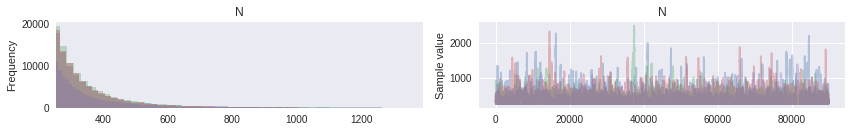

In [4]:
# plot the trace
pm.traceplot(tank_model_trace[tank_model_burn_in:])
plt.show()

So the mean here was 383, and the median was 323.

## Linear Regression and Robust Linear Regression and the GLM

For the following examples I've combined content from different sources and tutorials on the web. Some of the sources I used were:
* [PyMC3 documentation: linear regression](https://pymc-devs.github.io/pymc3/notebooks/GLM-linear.html)
* [PyMC3 documentation: robust linear regression](https://pymc-devs.github.io/pymc3/notebooks/GLM-robust.html)
* [Connect The Dots. Least Squares, Linear Regression, and Bayesian Regression](http://srome.github.io/Connect-The-Dots-Least-Squares-Linear-Regression-and-Bayesian-Regression/)

### Theory of a basic Linear Regression Model

$$\vec y=\bf X\vec\beta+\vec\epsilon$$

With $\epsilon_i\sim \mathcal{N}(0,\sigma^2)$ = independent Gaussian noise on the measurement error.

For [ordinary least squares (OLS)](https://en.wikipedia.org/wiki/Ordinary_least_squares) regression, we can quite conveniently solve this (find the $\beta$ values) using the Maximum Likelihood Estimate (MLE) which has a closed analytical form:
$$\hat\beta=({\bf X}^T{\bf X})^{-1}{\bf X}^T\vec y$$

Let's generate some toy data to play with:

In [5]:
def generate_glm_data(n=20, a=1, b=1, c=0, latent_error_y=10, error_pdf='norm', nr_outliers=3):  
    ''' 
    Create a toy dataset based on a very simple linear model 
    that we might imagine is a noisy physical process

    Model form: y ~ a + bx + cx^2 + e
    '''

    ## create linear or quadratic model
    ldf = pd.DataFrame({'x':stats.uniform.rvs(loc=0, scale=100, size=n)})
    ldf['y'] = a + b*(ldf['x']) + c*(ldf['x'])**2 
    ldf = ldf.sort_values('x').reset_index(drop=True)
    
    if error_pdf=='norm':
        ldf['e'] = stats.norm.rvs(loc=0, scale=latent_error_y, size=n)
    elif error_pdf=='cauchy':
        ldf['e'] = stats.cauchy.rvs(loc=0, scale=latent_error_y, size=n)
    elif error_pdf=='outliers':
        ldf['e'] = stats.norm.rvs(loc=0, scale=latent_error_y, size=n)
        for i in range(-nr_outliers, 0):
            ldf['e'].iloc[i] = np.abs(ldf['e'].iloc[i])*latent_error_y*10
    else:
        raise Exception('{} is not known as a valid value for error_pdf.'.format(error_pdf))

    ## add latent error noise
    ldf['y'] += ldf['e']

    return ldf

n=20 # 10000
glm_df = generate_glm_data(n=n, a=5, b=2, latent_error_y=30)
glm_df.head()

,x,y,e
0,2.058449,-18.123823,-27.240722
1,5.808361,-25.752389,-42.369111
2,13.949386,76.868235,43.969463
3,15.599452,29.425615,-6.773289
4,15.601864,38.229574,2.025846


So we generate data with an **intercept** of $a=5$ and an **inclination** of $b=2$.

In [6]:
glm_df.describe()

,x,y,e
count,20.000000,20.000000,20.000000
mean,42.900690,81.038623,-9.762758
std,29.534339,64.796675,29.295394
min,2.058449,-25.752389,-58.790104
25%,17.537339,29.248216,-32.430948
50%,36.809363,76.993812,-12.541147
75%,63.590782,128.940051,4.062235
max,96.990985,184.501137,55.568346


### Doing it with a pre-packaged scikit-learn solver

In [7]:
lr = LinearRegression()
X, y = glm_df['x'].values[:, np.newaxis], glm_df['y']
lr.fit(X, y)
lr.coef_.squeeze()
lr.intercept_, lr.coef_[0]

(-2.9341582334903933, 1.9573759850209729)

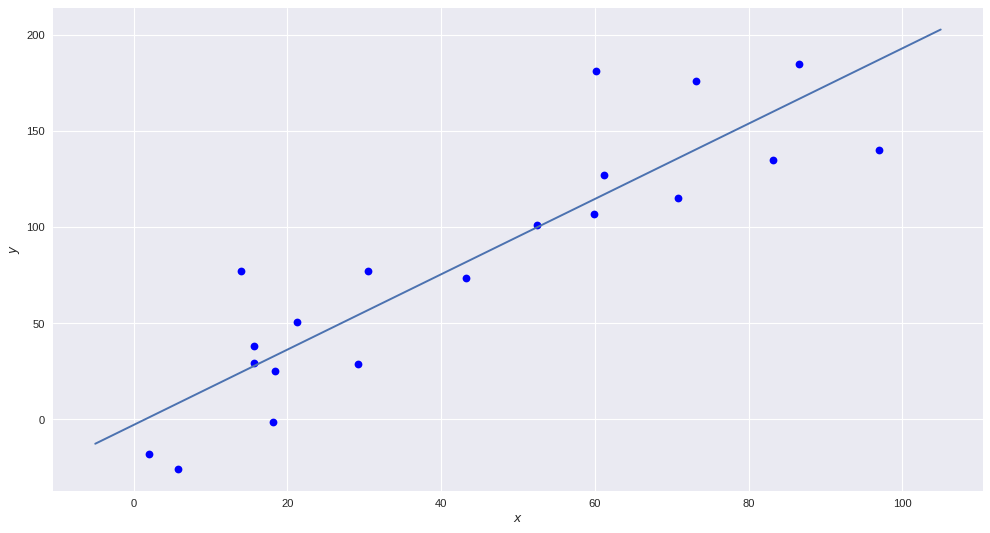

In [8]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.plot(glm_df['x'], glm_df['y'], 'bo')
plot_x = np.linspace(-5, 105, 100)
ax.plot(plot_x, lr.intercept_ + lr.coef_[0]*plot_x)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

### Doing it with PyMC3

#### Probabilistic Reformulation

Rather than using the formulation above:
$$\vec y=\bf X\vec\beta+\vec\epsilon$$
the probabilistic reformulation looks as follows:
$$\vec y\sim\mathcal{N}(\bf X\vec\beta,\,\sigma\cdot {\bf I})$$

In [9]:
%%time
with pm.Model() as glm_normal_model:
    # Define priors
    glm_normal_sigma     = pm.HalfCauchy('sigma', beta=10, testval=1.)
    glm_normal_intercept = pm.Normal('a', 0, sd=20)
    glm_normal_x_coeff   = pm.Normal('b', 0, sd=20)

    # Define likelihood
    glm_normal_likelihood = pm.Normal('y', mu=glm_normal_intercept + glm_normal_x_coeff * glm_df['x'], 
                                      sd=glm_normal_sigma, observed=glm_df['y'])

    # Inference!
    glm_normal_trace = pm.sample(3000, njobs=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 104.87:   9%|▉         | 18606/200000 [00:01<00:15, 11844.95it/s]   
Convergence archived at 19200
Interrupted at 19,200 [9%]: Average Loss = 23,194
100%|██████████| 3500/3500 [00:05<00:00, 630.74it/s]


CPU times: user 5.95 s, sys: 368 ms, total: 6.32 s
Wall time: 12.3 s


In [10]:
glm_normal_model_burn_in = 100  # throw away the first 100
# summarize the trace
pm.summary(glm_normal_trace[glm_normal_model_burn_in:], varnames=['a', 'b'])


a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -1.640           10.381           0.279            [-22.713, 18.392]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -22.253        -8.257         -1.671         5.059          19.242


b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.937            0.213            0.005            [1.499, 2.336]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.514          1.800          1.943          2.075          2.352



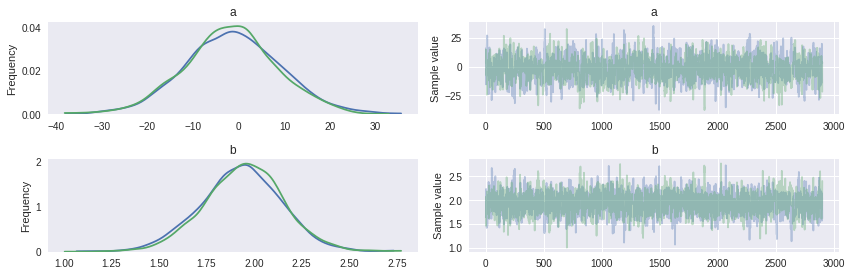

In [11]:
plt.figure(figsize=(7, 7))
pm.traceplot(glm_normal_trace[glm_normal_model_burn_in:], varnames=['a', 'b'])
plt.tight_layout();

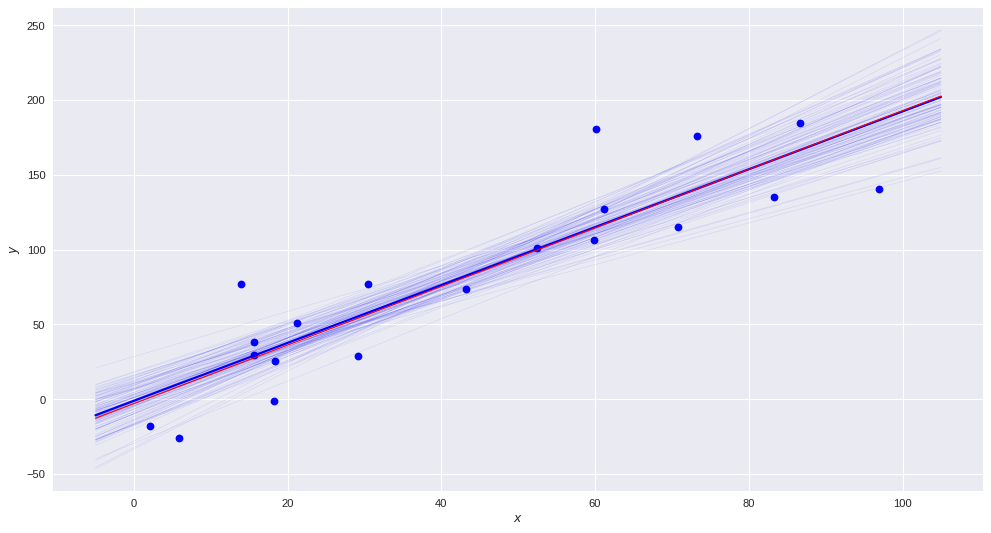

In [12]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.plot(glm_df['x'], glm_df['y'], 'bo')
plot_x = np.linspace(-5, 105, 100)
v1 = glm_normal_trace[glm_normal_model_burn_in::50]
ax.plot(plot_x, v1['a'] + v1['b']*plot_x[:,np.newaxis], c='blue',alpha =0.1, linewidth=0.5)
ax.plot(plot_x, v1['a'].mean() + v1['b'].mean()*plot_x, c='blue',linewidth=2)
ax.plot(plot_x, lr.intercept_ + lr.coef_[0]*plot_x, c='red',linewidth=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

In [13]:
# print('a/intercept: real: {:.2f}, sklearn: {:.2f}, pymc3: {:.2f}'.format(5.0, 0.66744, 0.873))
print('a/intercept: real: {:.2f}, sklearn: {:.2f}, pymc3: {:.2f}'.format(5.0, lr.intercept_, v1['a'].mean()))

a/intercept: real: 5.00, sklearn: -2.93, pymc3: -1.03


In [14]:
# print('b/inclination: real: {:.2f}, sklearn: {:.2f}, pymc3: {:.2f}'.format(2.0, 1.87342, 1.870))
print('b/inclination: real: {:.2f}, sklearn: {:.2f}, pymc3: {:.2f}'.format(2.0, lr.coef_[0], v1['b'].mean()))

b/inclination: real: 2.00, sklearn: 1.96, pymc3: 1.93


### Robust Linear Regression

In [15]:
n=50 # 10000
glm_outliers_df = generate_glm_data(n=n, a=5, b=2, latent_error_y=30, error_pdf='outliers', nr_outliers=5)
glm_outliers_df.head()

,x,y,e
0,2.116381,-20.144807,-29.377570
1,3.689329,12.043284,-0.335373
2,5.879602,-11.461403,-28.220607
3,7.396319,7.398951,-12.393687
4,14.447570,48.270514,14.375375


In [16]:
glm_outliers_df.describe()

,x,y,e
count,50.000000,50.000000,50.000000
mean,52.015932,966.349825,857.317960
std,29.675205,3431.670154,3408.339572
min,2.116381,-20.144807,-79.624870
25%,27.328193,50.611069,-21.898572
50%,51.831566,99.020017,-2.804396
75%,79.179201,159.804638,25.821095
max,99.875003,17675.576360,17470.854074


In [17]:
lr = LinearRegression()
X, y = glm_outliers_df['x'].values[:, np.newaxis], glm_outliers_df['y']
lr.fit(X, y)
lr.coef_.squeeze()
lr.intercept_, lr.coef_[0]

(-1442.1865375112147, 46.303819798417791)

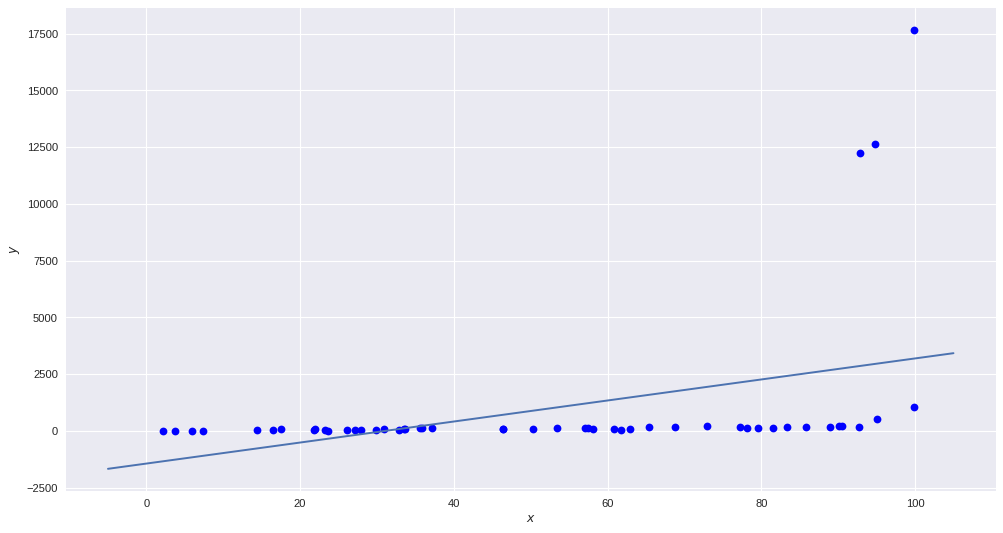

In [18]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.plot(glm_outliers_df['x'], glm_outliers_df['y'], 'bo')
plot_x = np.linspace(-5, 105, 100)
ax.plot(plot_x, lr.intercept_ + lr.coef_[0]*plot_x)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

In [19]:
%%time
with pm.Model() as glm_outliers_model:
    # Define priors
    glm_outliers_sigma     = pm.HalfCauchy('sigma', beta=10, testval=1.)
    glm_outliers_nu        = pm.Uniform('nu', lower=1, upper=100)
    glm_outliers_intercept = pm.Normal('a', 0, sd=20)
    glm_outliers_x_coeff   = pm.Normal('b', 0, sd=20)

    # Define likelihood
    glm_outliers_likelihood = \
        pm.StudentT('y', mu=glm_outliers_intercept + glm_outliers_x_coeff * glm_outliers_df['x'],
                    sd=glm_outliers_sigma, nu=glm_outliers_nu,
                    observed=glm_outliers_df['y'])

    # Inference!
    glm_outliers_trace = pm.sample(3000, njobs=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 323.92:   8%|▊         | 16731/200000 [00:01<00:19, 9447.91it/s] 
Convergence archived at 16800
Interrupted at 16,800 [8%]: Average Loss = 1,459.3
100%|██████████| 3500/3500 [00:08<00:00, 422.77it/s]


CPU times: user 8.24 s, sys: 336 ms, total: 8.58 s
Wall time: 17.7 s


In [20]:
glm_outliers_model_burn_in = 100  # throw away the first 100
# summarize the trace
pm.summary(glm_outliers_trace[glm_outliers_model_burn_in:], varnames=['a', 'b'])


a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -2.016           8.105            0.168            [-17.334, 14.556]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -17.862        -7.519         -1.964         3.387          14.232


b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.958            0.173            0.003            [1.625, 2.303]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.624          1.841          1.956          2.075          2.303



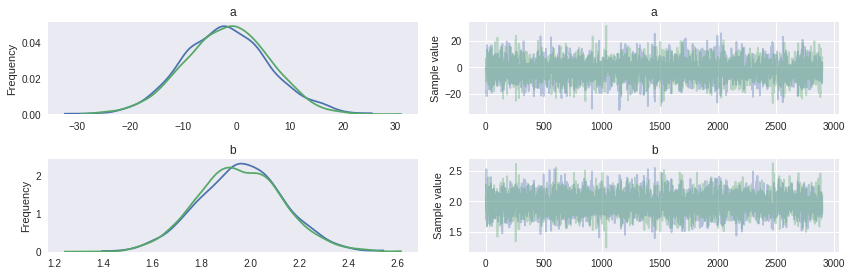

In [21]:
plt.figure(figsize=(7, 7))
pm.traceplot(glm_outliers_trace[glm_outliers_model_burn_in:], varnames=['a', 'b'])
plt.tight_layout();

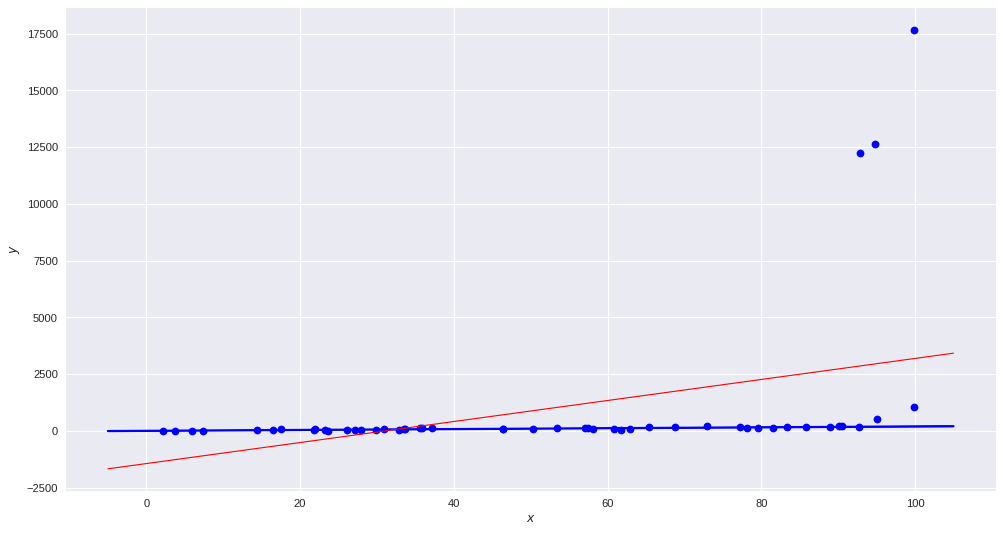

In [22]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.plot(glm_outliers_df['x'], glm_outliers_df['y'], 'bo')
plot_x = np.linspace(-5, 105, 100)
v1 = glm_outliers_trace[glm_outliers_model_burn_in::50]
ax.plot(plot_x, v1['a'] + v1['b']*plot_x[:,np.newaxis], c='blue',alpha =0.1, linewidth=0.5)
ax.plot(plot_x, v1['a'].mean() + v1['b'].mean()*plot_x, c='blue',linewidth=2)
ax.plot(plot_x, lr.intercept_ + lr.coef_[0]*plot_x, c='red',linewidth=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

## Mixture Models

### Finite Mixture Models

The following example is taken from the [PyMC3 documentation](https://pymc-devs.github.io/pymc3/notebooks/gaussian_mixture_model.html).

In [23]:
nr_centers=3
ndata = 500
def generate_mixture_data(nr_centers=3, n=500, spread=5):
    labs = nr_centers//2
    lstart = -labs
    lend = labs + 1
    lcenters = np.array(range(lstart, lend))*spread

    # simulate data from mixture distribution
    v = np.random.randint(0, nr_centers, n)
    ldata = lcenters[v] + stats.norm.rvs(size=n)
    return ldata

data = generate_mixture_data(nr_centers=nr_centers, n=ndata)

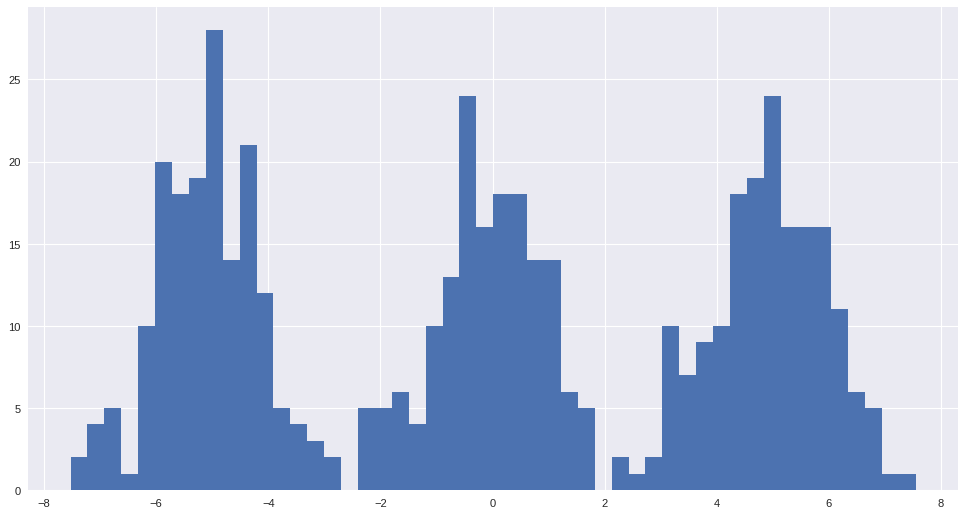

In [24]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.hist(data, bins=50)
pass

In [25]:
# setup model
with pm.Model() as fixed_mixture_model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=nr_centers)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))

    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=nr_centers)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1] - means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2] - means[1] < 0, -np.inf, 0))

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category', p=p, shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs', mu=means[category], sd=sd, observed=data)

In [26]:
%%time
with fixed_mixture_model:
    fixed_mixture_model_step1 = pm.Metropolis(vars=[p, sd, means])
    fixed_mixture_model_step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
    fixed_mixture_model_trace = pm.sample(10000, step=[fixed_mixture_model_step1, fixed_mixture_model_step2])

/home/user/cs/local/install/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  app.launch_new_instance()
100%|██████████| 10500/10500 [01:14<00:00, 141.21it/s]

CPU times: user 1min 16s, sys: 3.83 s, total: 1min 20s
Wall time: 1min 16s


In [27]:
fixed_mixture_model_trace_burn_in = 2000
pm.summary(fixed_mixture_model_trace[glm_outliers_model_burn_in:], varnames=['means', 'p'])


means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -4.910           0.412            0.038            [-5.277, -3.823]
  -0.671           1.248            0.124            [-3.486, 0.083]
  4.682            0.558            0.055            [3.360, 5.099]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -5.243         -5.115         -5.066         -4.991         -3.700
  -3.655         -0.183         -0.110         -0.048         0.069
  3.295          4.835          4.912          4.981          5.073


p:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.302            0.077            0.007            [0.113, 0.379]
  0.327            0.031            0.002            [0.270, 

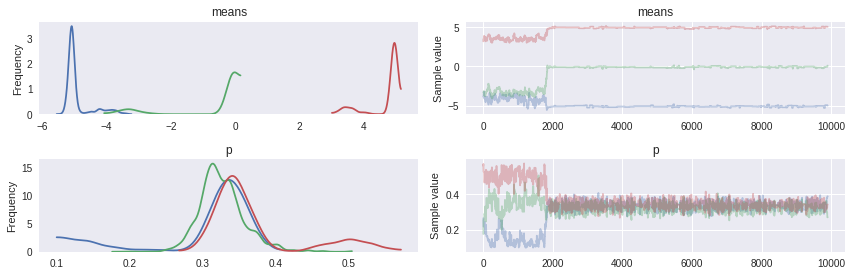

In [28]:
plt.figure(figsize=(7, 7))
pm.traceplot(fixed_mixture_model_trace[glm_outliers_model_burn_in:], varnames=['means', 'p'])
plt.tight_layout();

### Infinite Mixture Models: Clustering the McDonalds Menu

This example is taken from here: [Infinite Mixture Models with Nonparametric Bayes and the Dirichlet Process](http://blog.echen.me/2012/03/20/infinite-mixture-models-with-nonparametric-bayes-and-the-dirichlet-process/). This is also by far the best explanation I've found for the so called **Stick-Breaking Process**, and how it is equivalent to the **Chinese Restaurant Process**, the **Polya Urn Model** and the **Dirichlet Process**.

In [29]:
FILENAME = "mcdonalds-normalized-data.tsv"

# Note: you'll have to remove the last "name" column in the file (or
# some other such thing), so that all the columns are numeric.
df = pd.DataFrame.from_csv(FILENAME, sep='\t', header=0, index_col=None)
df.head()

,total_fat,cholesterol,sodium,dietary_fiber,sugars,protein,vitamin_a_dv,vitamin_c_dv,calcium_dv,iron_dv,calories_from_fat,saturated_fat,trans_fat,carbohydrates,name
0,0.256972,-0.043135,0.623001,0.737522,-1.187087,0.563394,-0.317138,-0.139953,-0.485008,2.002784,0.237144,0.059024,2.078751,-0.525870,Hamburger
1,0.426906,0.216793,0.912521,0.531005,-1.237093,0.639829,-0.220048,-0.142032,-0.170976,1.527630,0.455109,0.574437,1.660648,-0.751855,Cheeseburger
2,0.948294,0.594870,0.990855,0.202455,-1.288236,0.900404,-0.206808,-0.145340,-0.286954,1.311651,0.971714,1.003947,3.846183,-1.280131,DoubleCheeseburger
3,0.797274,0.476721,0.815308,0.292716,-1.262738,0.884814,-0.242453,-0.144432,-0.352148,1.588547,0.778464,0.618489,2.786308,-1.161608,McDouble
4,0.893391,0.553171,0.797632,0.409525,-1.266509,0.902107,-0.221952,-0.140197,-0.263338,1.481046,0.848911,0.877620,3.259275,-1.261429,QuarterPounder®withCheese+


In [30]:
x = df.iloc[:,:-1].values

gmm = mixture.BayesianGaussianMixture(n_components = 25, weight_concentration_prior_type='dirichlet_process')
gmm.fit(x)
clusters = gmm.predict(x)

# https://github.com/echen/dirichlet-process/blob/master/plots.R
df['cluster_id'] = pd.Series(clusters, index=df.index)
df.head()

,total_fat,cholesterol,sodium,dietary_fiber,sugars,protein,vitamin_a_dv,vitamin_c_dv,calcium_dv,iron_dv,calories_from_fat,saturated_fat,trans_fat,carbohydrates,name,cluster_id
0,0.256972,-0.043135,0.623001,0.737522,-1.187087,0.563394,-0.317138,-0.139953,-0.485008,2.002784,0.237144,0.059024,2.078751,-0.525870,Hamburger,9
1,0.426906,0.216793,0.912521,0.531005,-1.237093,0.639829,-0.220048,-0.142032,-0.170976,1.527630,0.455109,0.574437,1.660648,-0.751855,Cheeseburger,9
2,0.948294,0.594870,0.990855,0.202455,-1.288236,0.900404,-0.206808,-0.145340,-0.286954,1.311651,0.971714,1.003947,3.846183,-1.280131,DoubleCheeseburger,15
3,0.797274,0.476721,0.815308,0.292716,-1.262738,0.884814,-0.242453,-0.144432,-0.352148,1.588547,0.778464,0.618489,2.786308,-1.161608,McDouble,15
4,0.893391,0.553171,0.797632,0.409525,-1.266509,0.902107,-0.221952,-0.140197,-0.263338,1.481046,0.848911,0.877620,3.259275,-1.261429,QuarterPounder®withCheese+,15


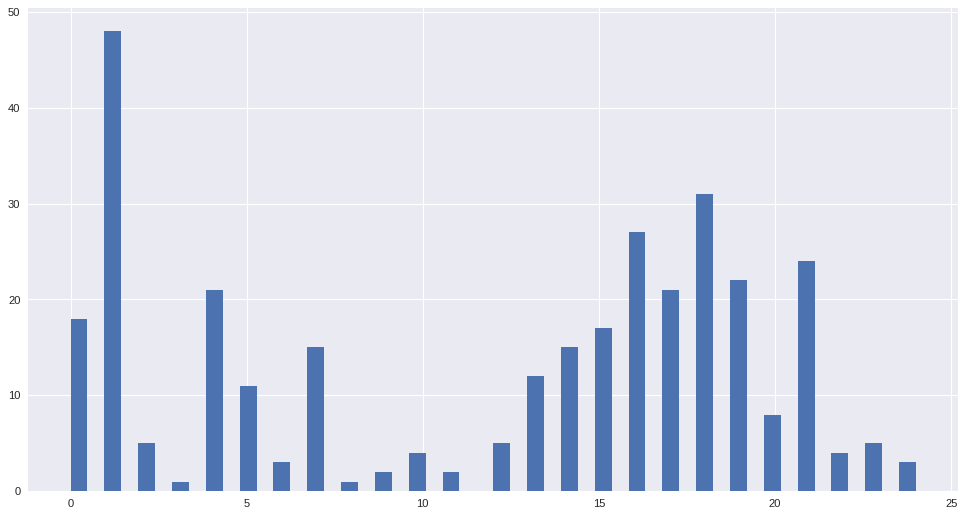

In [31]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.hist(df['cluster_id'], bins=50)
pass

In [32]:
df[df['cluster_id']==2]['name']

39                  ChickenMcNuggets®(4piece)
40                  ChickenMcNuggets®(6piece)
41                 ChickenMcNuggets®(10piece)
46    ChickenSelects®PremiumBreastStrips(3pc)
47    ChickenSelects®PremiumBreastStrips(5pc)
Name: name, dtype: object

Have a look at [Infinite Mixture Models with Nonparametric Bayes and the Dirichlet Process](http://blog.echen.me/2012/03/20/infinite-mixture-models-with-nonparametric-bayes-and-the-dirichlet-process/) and scroll down to "Let’s dive into one of these clusterings" to see some of the clusters.

![Cluster 1 (Desserts)](http://i.imgur.com/oM1aPCE.png)

![Cluster 2 (Sauces)](http://i.imgur.com/3bOYEBz.png)

![Cluster 8 (Sugary Drinks)](http://i.imgur.com/MNdKmrr.png)

![Cluster 9 (Breakfast Foods)](http://i.imgur.com/m67oVsY.png)

Have a look at [scikit-learn](http://scikit-learn.org)'s [Gaussian mixture models](http://scikit-learn.org/stable/modules/mixture.html) documentation to learn more about this functionality.

## Switchpoint analysis

### Single switchpoint

The example is taken directly from the PyMC3 documentation: [Case study 2: Coal mining disasters](https://pymc-devs.github.io/pymc3/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters). You can look there for more details and explanations.

In [33]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)
disaster_data_df = pd.DataFrame({'disaster_count':disaster_data},index=year)

#with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#    print(disaster_data_df)
#print(pd.get_option('display.max_rows'))
#pd.set_option('display.max_rows', 60)
# trick to show full dataframe all entries:
display(HTML(disaster_data_df.to_html()))

,disaster_count
1851,4.0
1852,5.0
1853,4.0
1854,0.0
1855,1.0
1856,4.0
1857,3.0
1858,4.0
1859,0.0
1860,6.0


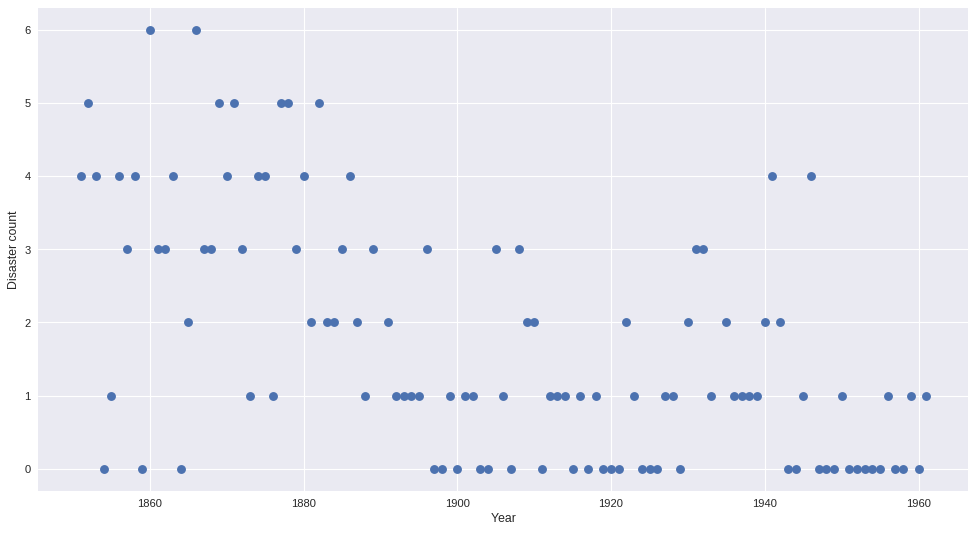

In [34]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.plot(year, disaster_data, 'o', markersize=8);
ax.set_ylabel("Disaster count")
ax.set_xlabel("Year")

In [35]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= year, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

In [36]:
%%time
with disaster_model:
    disaster_model_trace = pm.sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to disasters_missing
100%|██████████| 10500/10500 [00:08<00:00, 1198.16it/s]

CPU times: user 11.1 s, sys: 216 ms, total: 11.3 s
Wall time: 11.1 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6986d32b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc68a793080>]], dtype=object)

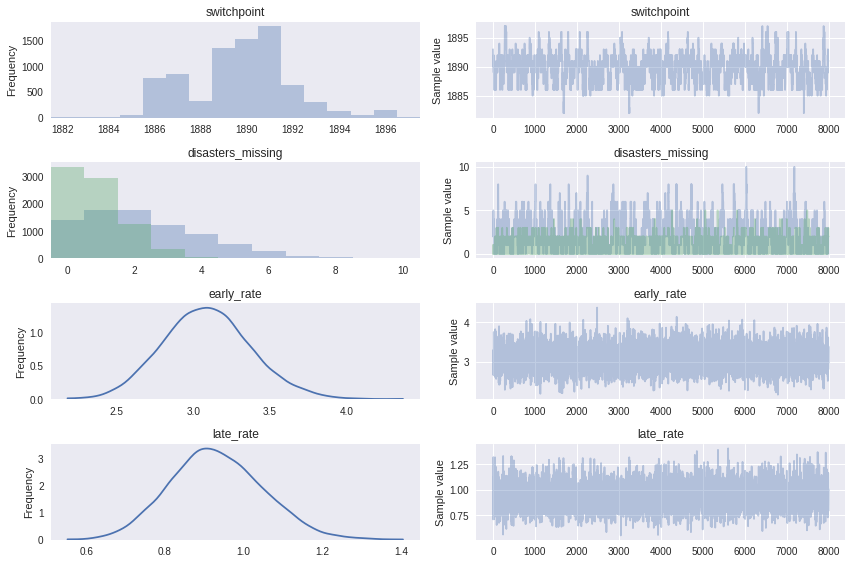

In [37]:
disaster_model_trace_burn_in = 2000
pm.traceplot(disaster_model_trace[disaster_model_trace_burn_in:])

In [38]:
pm.summary(disaster_model_trace[disaster_model_trace_burn_in:]) # , varnames=['means', 'p']


switchpoint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1889.703         2.283            0.125            [1885.000, 1893.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1886.000       1888.000       1890.000       1891.000       1895.000


disasters_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.225            1.770            0.095            [0.000, 6.000]
  0.853            0.903            0.025            [0.000, 3.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          1.000          2.000          3.000          6.000
  0.000     

### Multiple switchpoints: Bayesian Blocks / Data Binning / Data-Bucketing / Discretization

In a similar way like with our mixture model above where we treated the case with a fixed number of mixtures within PyMC3, but used pre-packaged algorithms for the infinite case, here I simply point you into the right direction.

We will look at a very specific case here: often you will need to [discretize a continuous feature](https://en.wikipedia.org/wiki/Discretization_of_continuous_features), also called [binning](https://en.wikipedia.org/wiki/Data_binning) or bucketing, e.g. you have some continuous data, but you want to make the representation more compact by treating the data as some countable number of cases.

There have been many rules of thumb used in the literature are [Scott’s Rule](https://academic.oup.com/biomet/article-abstract/66/3/605/232642/On-optimal-and-data-based-histograms?redirectedFrom=fulltext) and the [Freedman-Diaconis Rule](https://link.springer.com/article/10.1007%2FBF01025868). Both are based on assumptions about the form of the underlying data distribution. A slightly more rigorous approach is [Knuth’s rule](https://arxiv.org/abs/physics/0605197), which is based on optimization of a Bayesian fitness function across fixed-width bins.

A further generalization of this approach is that of [Bayesian Blocks](https://arxiv.org/abs/1207.5578), which optimizes a fitness function across an arbitrary configuration of bins, which need not be of equal width. This paper is quite accessible and the method can be understood as a switchpoint analysis with an infinite number of possible switchpoints.

The [astroML](http://www.astroml.org) package includes an [implementation in python](http://www.astroml.org/user_guide/density_estimation.html#bayesian-blocks-histograms-the-right-way) for all the above algorithms and an explanation of the algorithm is given in the blog post [Dynamic Programming in Python: Bayesian Blocks](https://jakevdp.github.io/blog/2012/09/12/dynamic-programming-in-python/).

Here is an example:

In [39]:
SEED = 42
np.random.seed(SEED)
x = np.random.normal(size=1000)
bins = astroML.density_estimation.bayesian_blocks(x, p0=1.5)
#bins = astroML.density_estimation.bayesian_blocks(x, gamma=0.999)
bins

array([-3.24126734, -2.96907699, -2.67392823, -2.63535746, -2.5456948 ,
       -2.25652824, -2.07765982, -2.04048352, -2.03867836, -1.71902618,
       -1.52435604, -1.51501914, -1.43331863, -1.4079865 , -1.40706244,
       -1.02545147, -0.57689776, -0.57572803, -0.43988777, -0.07577381,
        0.13185513,  0.16865882,  0.38469141,  0.47144196,  0.47371268,
        0.83816783,  1.20386144,  1.90310481,  2.67627562,  3.85273149])

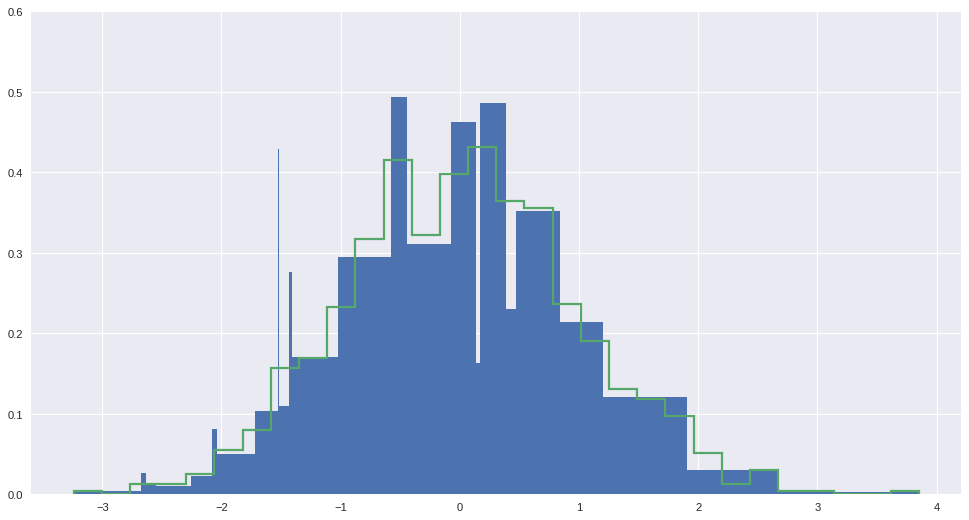

In [40]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.hist(x, bins, normed=True)
ax.hist(x, histtype='step', linewidth=2, bins=30, normed=True)
ax.set_ylim(0.0,0.6)
#astroML.plotting.hist(x, bins='blocks', p0=0.5)
pass

#### Supervised Learning: Data Binning / Data-Bucketing / Discretization

Just as a side remark, in case you have a supervised learning task where you want to classify data according to some features and you want to discretize some of the continuous features then a good approach for finding the bin boundaries is [binning data using decision tree regression](https://sites.google.com/site/kittipat/programming-with-python/binningdatausingdecisiontreeregression). The decision tree internally already builds up decision tree boundaries and those you can use as good bin boundaries points.

More theory is given in [A Simple Guide to Entropy-Based Discretization](http://kevinmeurer.com/a-simple-guide-to-entropy-based-discretization/).

Also have a look at [decision trees in python with scikit-learn and pandas](http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html) and its associated [gist](https://gist.github.com/cstrelioff/8fefa9a43e82d96e9f0c) to learn more about how to use decision trees in scikit-learn.

## Stochastic Volatility Model

The following example is taken from [Probabilistic Programming in Python using PyMC](https://arxiv.org/abs/1507.08050) by John Salvatier, Thomas Wiecki, Christopher Fonnesbeck. A similar [example](https://pymc-devs.github.io/pymc3/notebooks/stochastic_volatility.html) is also part of the PyMC3 documentation.

One elegant example of how Probabilistic Programming can infer unobservable quantities of the stock market is the stochastic volatility model. Volatility is an important concept of quantitative finance as it relates to risk. Unfortunately, as Tony Cooper reminds us:

> "Volatility is a strange thing - it exists but you can't measure it."
>
> -- Tony Cooper on [Quantopian forums)(https://www.quantopian.com/posts/system-based-on-easy-volatility-investing-by-tony-cooper-at-double-digit-numerics).

If we can't measure something, the next best thing we can do is to try and model it. One way to do this is in a probabilistic framework is the concept of stochastic volatility: If we assume that returns are [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution), the volatility would be captured as the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) of the normal distribution. Thus, the standard deviation gives rise to stochastic volatility. Intuitively we would assume that the standard deviation is high during times of market turmoil like the 2008 crash.

So the trivial thing to do would be to look at the rolling standard deviation of returns. But this is unsatisfying for multiple reasons:
* it often lags behind volatility,
* is a rather unstable measure,
* strongly dependent on the window size with no principled way of choosing it.

These properties are outlined in the plot below. The larger the window size, the more lag, the smaller the window size, the more unstable the estimate gets.

As we will see, the stochastic volatility model does a better job at all of them. But before we look at that we need to establish one more insight into the nature of volatility: it tends to cluster. This is nicely demonstrated by looking at the returns of the S&P 500 above. As you can see, during the 2008 financial crisis there is a lot volatility in the stock market (huge positive and negative daily returns) that gradually decreases over time.

So how do we model this clustering property? The Stochastic Volatility model assumes that that the standard-deviation of the returns follow a [random-walk process](https://en.wikipedia.org/wiki/Random_walk). You can read the Wikipedia article I linked but essentially this process allows for slow, gradual changes over time.

What is interesting is that we can model the standard deviation itself to follow a random walk. Intuitively, we allow standard deviation to change over time but only ever so slightly at each time-point.

The plot further down below shows the latent volatility inferred from the model based on the market data. The lines represent the standard deviation of the Normal distribution we assume for the daily returns.

As you can see, the estimated volatility is much more robust. Moreover, all parameters are estimated from the data while we would have to find a reasonable window length for the rolling standard deviation ourselves. Finally, we do not just get a single estimate as with the rolling standard deviation but rather many solutions that are likely. This provides us with a measure of the uncertainty in our estimates and is represented by the width of the line above.

In summary, Bayesian statistics and Probabilistic Programming is an extremely powerful framework for Quantitative Finance as it provides:
* a principled framework for modeling latent, unobservable causes, as demonstrated by the stochastic volatility model;
* a measure of uncertainty in our estimates;
* powerful sampling methods that allow automatic estimation of highly complex models.

This example has 400+ parameters so using common sampling algorithms like Metropolis-Hastings would get bogged down, generating highly autocorrelated samples. Instead, we use NUTS, which is dramatically more efficient.

### The Model

Asset prices have time-varying volatility (variance of day over day returns). In some periods, returns are
highly variable, while in others they are very stable. Stochastic volatility models address this with a latent
volatility variable, which changes over time. The following model is similar to the one described in the NUTS
paper ([Hoffman & Gelman, 2014](http://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf), p. 21).

$$
\begin{align}
\sigma&\sim\hbox{exp}(50)\\
\nu&\sim\hbox{exp}(.1)\\
s_i&\sim\mathcal{N}(s_{i-1},\sigma^{-2})\\
log(\frac{y_i}{y_{i-1}})&\sim t(\nu, 0, e^{-2\cdot s_i})\\
\end{align}
$$

Here, $y$ is the daily return series which is modeled with a Student-t distribution with an unknown degrees
of freedom parameter, and a scale parameter determined by a latent process $s$. The individual $s_i$ are the
individual daily log volatilities in the latent log volatility process.

### Build the model

Our data consist of daily returns of the S&P 500 during the 2008 financial crisis.

In [41]:
sp500_model_n = 400
sp500_model_returns = np.genfromtxt(pm.get_data("SP500.csv"))[-sp500_model_n:]
sp500_model_returns[-5:]

array([ 0.00553 , -0.001764,  0.005191, -0.003814, -0.002478])

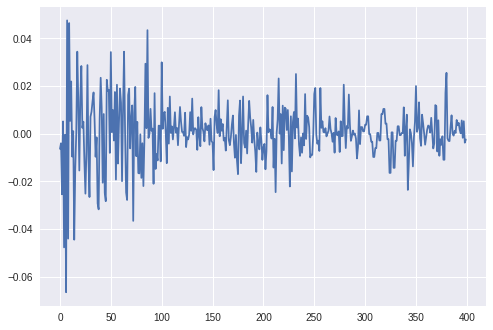

In [42]:
plt.plot(sp500_model_returns)

Sometimes some of the probability distributions are parametrized with different parameters, e.g. in the below `pm.GaussianRandomWalk` may be parametrized in terms of $\tau$ where $\tau=1/\sigma^2$ (there is no documentation in the PyMC3 documenation about the `pm.GaussianRandomWalk`; you have to look this up in the sourcecode).

The same is true with [different parametrizations](https://en.wikipedia.org/wiki/Student%27s_t-distribution#In_terms_of_inverse_scaling_parameter_.CE.BB) of the Student T distribution, e.g. $\lambda=1/\sigma^2$.

In [43]:
with pm.Model() as sp500_model:
    sp500_model_sigma = pm.Exponential('sigma', 1./.02, testval=.1)

    sp500_model_nu = pm.Exponential('nu', 1./10)
    sp500_model_s = pm.GaussianRandomWalk('s', sd=sp500_model_sigma, shape=sp500_model_n)
    
    sp500_model_volatility_process = pm.Deterministic('volatility_process', pm.math.exp(sp500_model_s))

    sp500_model_r = pm.StudentT('r', 
                                nu=sp500_model_nu,
                                sd=sp500_model_volatility_process, 
                                observed=sp500_model_returns)

In [44]:
%%time
with sp500_model:
    sp500_model_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -1,130.4:  34%|███▍      | 67888/200000 [00:16<00:33, 4001.99it/s]
Convergence archived at 68100
Interrupted at 68,100 [34%]: Average Loss = 505.57
100%|██████████| 2000/2000 [01:28<00:00, 22.69it/s]

CPU times: user 1min 50s, sys: 1.96 s, total: 1min 52s
Wall time: 1min 50s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc655698588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc6680f9b38>]], dtype=object)

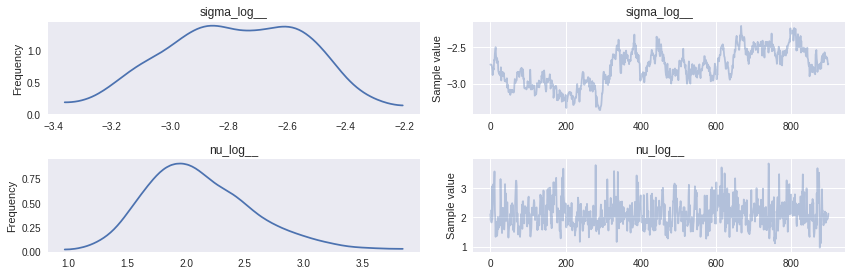

In [45]:
sp500_model_burn_in=100
fig=plt.figure(figsize=(12,6), dpi= 80, facecolor='w', edgecolor='k')
# pm.traceplot(sp500_model_trace[sp500_model_burn_in:])
pm.traceplot(sp500_model_trace[sp500_model_burn_in:], sp500_model.vars[:-1])

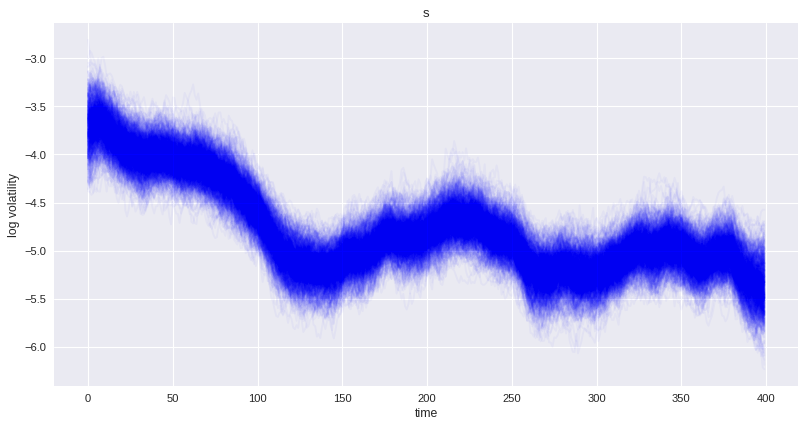

In [46]:
sp500_model_thinning=10
fig=plt.figure(figsize=(12,6), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.set_title('s')
ax.plot(sp500_model_trace[sp500_model_burn_in:]['s'].T, 'b', alpha=.03);
ax.set_xlabel('time')
ax.set_ylabel('log volatility')

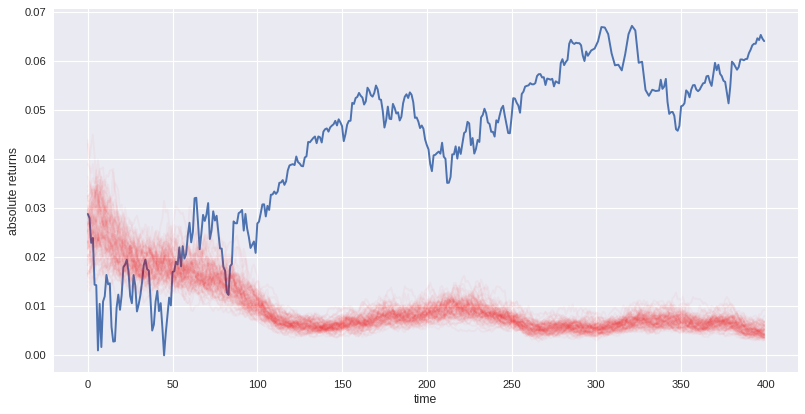

In [47]:
fig=plt.figure(figsize=(12,6), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
# ax.plot(np.abs(sp500_model_returns))
ax.plot(sp500_model_returns.cumsum()*.2+0.03)#
sd = np.exp(sp500_model_trace[sp500_model_burn_in:]['s'][::sp500_model_thinning].T)
ax.plot(sd, 'r', alpha=.03);
ax.set_xlabel('time')
ax.set_ylabel('absolute returns')

## Finite mixture model with time-varying probabilities

* [Finite mixture model with time-varying probabilities](https://modernstatisticalworkflow.blogspot.de/2016/10/finite-mixture-model-with-time-varying.html)

## Bayesian Deep Learning

* [Neural Networks in PyMC3 estimated with Variational Inference](http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/)

# Appendix: Further Reading

## Usage of Bayesian Methods

By far the most instructive book that teaches you Bayesian methods is the book [Doing Bayesian Data Analysis, Second Edition: A Tutorial with R, JAGS, and Stan 2nd Edition by John Kruschke](https://www.amazon.com/Doing-Bayesian-Data-Analysis-Second/dp/0124058884). I highly recommend the book!

* [Book Site](https://sites.google.com/site/doingbayesiandataanalysis/) with [source](https://sites.google.com/site/doingbayesiandataanalysis/software-installation/DBDA2Eprograms.zip?attredirects=0&d=1).
* [Book Blog](http://doingbayesiandataanalysis.blogspot.de/)

Some people have translated the examples in the book from R and JAGS to python and PyMC3:
* [Doing Bayesian Data Analysis in Python](http://doingbayesiandataanalysis.blogspot.de/2014/09/doing-bayesian-data-analysis-in-python.html)
  * [Osvaldo Martin: aloctavodia/Doing_bayesian_data_analysis: GitHub](https://github.com/aloctavodia/Doing_bayesian_data_analysis)
    * [jupyter nbviewer](http://nbviewer.jupyter.org/github/aloctavodia/Doing_bayesian_data_analysis/blob/master/IPython/Kruschkes_Doing_Bayesian_Data_Analysis_in_PyMC3.ipynb)


I also can highly recommend to read the [Stan manual](https://github.com/stan-dev/stan/releases/download/v2.16.0/stan-reference-2.16.0.pdf) from cover to cover. I postponed reading it for too long, because I thought it is a "boring" manual, but actually it explains quite a lot of modeling techniques!

Another quite good free online book is [Probabilistic Programming & Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) by Cameron Davidson-Pilon (also available as a printed [book](https://www.amazon.com/Bayesian-Methods-Hackers-Probabilistic-Addison-Wesley/dp/0133902838))

While the book [Machine Learning: A Probabilistic Perspective](https://www.amazon.com/Machine-Learning-Probabilistic-Perspective-Computation/dp/0262018020) is not directly related to Markov Chain Monte Carlo methods it gives a good overview over many different probability models. The art in making best use of MCMC is in finding the right model and this book looks in detail into many different probability/likelihood models and especially important sets them into context and compares them. The book is not always easy to read and sometimes the notation is confusing. Nevertheless it helps a lot by pointing you into the right direction!

## MCMC internals: how it all works

If you want to understand what is going on under the hood then I recommend to start with the following video from [Michael Betancourt](https://github.com/betanalpha), a member of the [Stan](http://mc-stan.org) team: [Video: "Everything You Should Have Learned About Markov Chain Monte Carlo"](https://www.youtube.com/watch?v=DJ0c7Bm5Djk&feature=youtu.be&t=4h40m9s).

And the paper [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434) also by Michael Betancourt goes into more details. I suggest reading this paper together with [Logic, Probability, and Bayesian Inference: A Conceptual Introduction to the Foundations of Applied Inference for Scientists and Engineers ](https://github.com/betanalpha/stan_intro/blob/master/stan_intro.pdf).

## People to follow

The following list mentions some people who are very active in the MCMC area. It is worthwhile to look at some of the things they've done. Below I've given links to one of their web-sites, but often they are active in many different places in the web, e.g. simply use Google to search for them and their work:
* [Michael Betancourt](http://betanalpha.github.io/) (some of his case studies are [here](http://andrewgelman.com/2017/03/07/fistful-stan-case-studies-divergences-bias-identifying-mixtures-weakly-informative-priors/))
* [Austin Rochford](http://austinrochford.com/posts.html)
* [Chris Fonnesbeck](https://github.com/fonnesbeck)
* [Thomas Wiecki](https://twiecki.github.io/) (you can support him on [patreon](https://www.patreon.com/twiecki), so that he can do more quality work on PyMC3)
* [Jim Savage](https://modernstatisticalworkflow.blogspot.de) (he is currently in the process of writing a [book](https://www.amazon.de/Bayesian-Econometrics-Stan-James-Savage/dp/1138626511))
* [Cam Davidson-Pilon](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)

## News from PyMC3

If you want ot learn more about PyMC3 then the best way is to follow some of the examples that others have done. Very noteworthy are the recent improvements in [PyMC3 verion 3.1](http://twiecki.github.io/blog/2017/07/05/new-in-pymc3-31/).

All around MCMC is an extremely active area of development. It is worthwhile to check regularly.

In [48]:
notebook_end_time = datetime.now()
notebook_run_time = notebook_end_time - notebook_start_time
print("notebook_run_time: {}".format(notebook_run_time))

notebook_run_time: 0:04:15.424642
